In [1]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

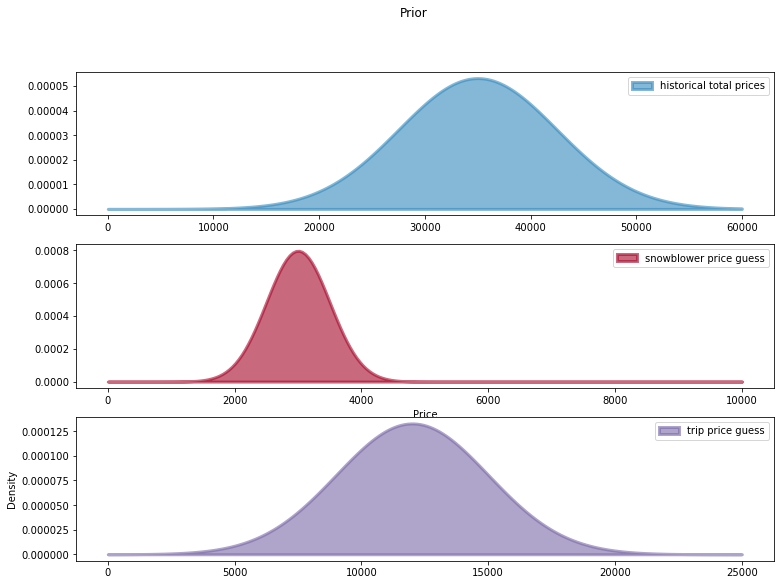

In [2]:
figsize(12.5 ,9)

norm_pdf = stats.norm.pdf
plt.subplot(311)
x = np.linspace(0, 60000, 200)
plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
                color="#348ABD", lw=3 ,alpha=0.6,
                label="historical total prices")

plt.legend()

plt.subplot(312)
x = np.linspace(0, 10000, 200)
plt.fill_between(x, 0,norm_pdf(x, 3000, 500),
                color="#A60628", lw=3, alpha=0.6,
                label="snowblower price guess")
plt.xlabel("Price")
plt.legend()

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                      color="#7A68A6", lw=3, alpha=0.6,
                      label="trip price guess")
plt.legend()

plt.ylabel("Density")
plt.suptitle("Prior")

In [3]:
import pymc as pm

data_mu = [3e3, 12e3]
data_std = [5e2, 3e3]
mu_prior = 35e3
std_prior = 75e2

true_price = pm.Normal("true_price", mu_prior, 1.0 / std_prior**2)
prize_1 = pm.Normal("first_prize", data_mu[0], 1.0/ data_std[0]**2)
prize_2 = pm.Normal("second_prize", data_mu[1], 1.0 / data_std[1]**2)
price_estimate = prize_1 + prize_2

@pm.potential
def error(true_price=true_price, price_estimate=price_estimate):
    return pm.normal_like(true_price, price_estimate, 1/ (3e3)**2)

mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])

mcmc.sample(50000, 10000)

price_trace = mcmc.trace("true_price")[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 5.8 sec

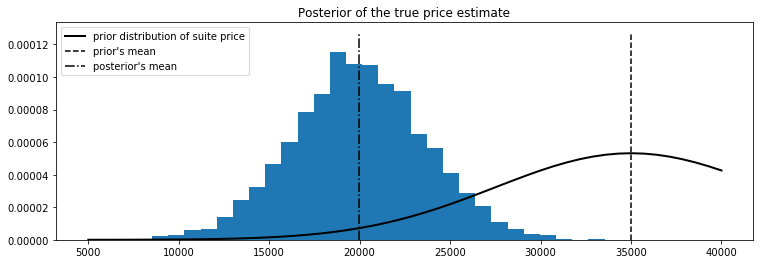

In [4]:
figsize(12.5, 4)
import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2,
        label = "prior distribution of suite price")

_hist = plt.hist(price_trace, bins=35, normed=True, histtype="stepfilled")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), linestyles="--", label="prior's mean")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), linestyles ="-.", label="posterior's mean")

plt.title("Posterior of the true price estimate")
plt.legend(loc="upper left")

In [5]:
loss = np.zeros_like(price_trace)
guess = np.linspace(5000,50000,70)
price_trace

array([ 23374.36182925,  23374.36182925,  23374.36182925, ...,
        23635.9679196 ,  23635.9679196 ,  23635.9679196 ])

In [6]:
guess=21500
ix = price_trace < guess
ix

array([False, False, False, ..., False, False, False], dtype=bool)

In [7]:
~ix
len(loss[~ix])

13236

In [8]:
close_mask = [abs(price_trace - guess) <= 250]
print(close_mask[0], len(close_mask[0]))

[False False False ..., False False False] 40000


In [9]:
a = np.array([1,2,3,4,5])
b = np.array([False, True, False, True, False])
a[b]

array([2, 4])

(5000, 30000)

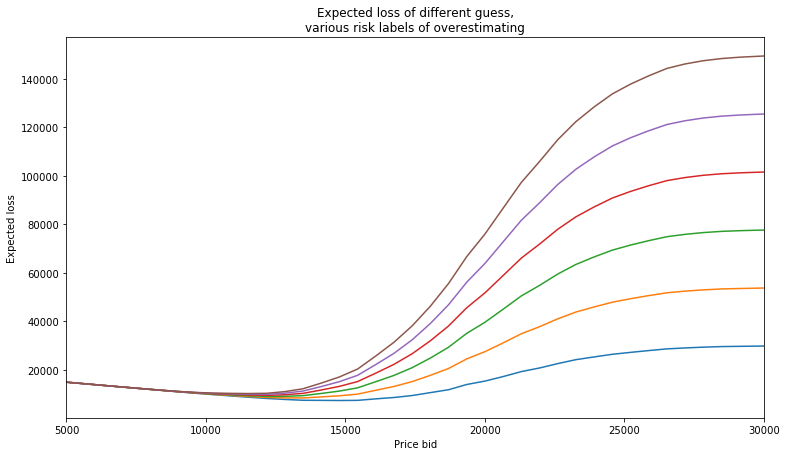

In [10]:
figsize(12.5, 7)

def showdown_loss(guess, true_price, risk=80000):
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    loss[~ix] = np.abs(guess - true_price[~ix])
    close_mask = [abs(true_price - guess) <= 250]
    loss[close_mask] = -2 * true_price[close_mask]
    loss[ix] = risk
    return loss

guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: showdown_loss(guess, price_trace,risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)
    
plt.title("Expected loss of different guess,\n"
         "various risk labels of overestimating")
plt.xlabel("Price bid")
plt.ylabel("Expected loss")
plt.xlim(5000, 30000)

minimum as risk 30000: 14574.91
minimum as risk 54000: 13227.54
minimum as risk 78000: 12496.51
minimum as risk 102000: 12465.09
minimum as risk 126000: 11855.72
minimum as risk 150000: 11853.96


/Users/hiroki/.pyenv/versions/anaconda3-4.0.0/envs/py3_personal/lib/python3.5/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "upper letf". Falling back on "best"; valid locations are
	upper center
	lower right
	best
	lower center
	right
	upper left
	lower left
	center left
	center
	center right
	upper right

  six.iterkeys(self.codes))))


(-1000, 80000)

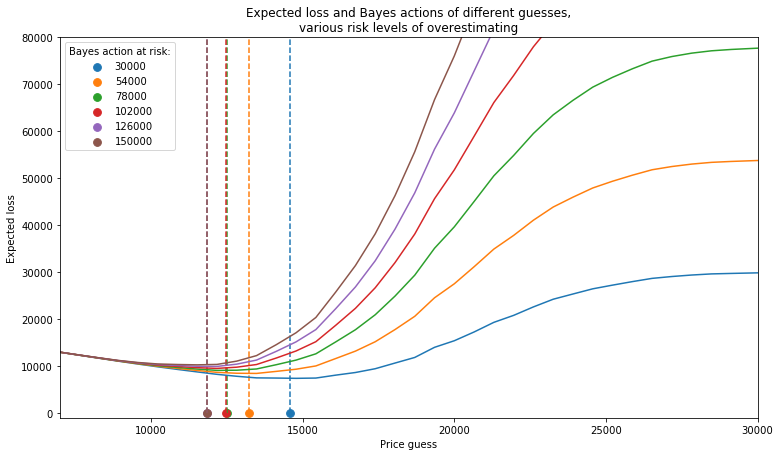

In [11]:
import scipy.optimize as sop

ax = plt.subplot(111)

for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,), disp=False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results, color=_color['color'])
    plt.scatter(_min_results, 0, s=60, color=_color['color'], label="%d" % _p )
    plt.vlines(_min_results, 0, 120000, color=_color['color'], linestyles="--")
    print("minimum as risk %d: %.2f" % (_p, _min_results))
    
plt.title("Expected loss and Bayes actions of different guesses,\n"
         "various risk levels of overestimating")
plt.legend(loc="upper letf", scatterpoints=1, title="Bayes action at risk:")
plt.xlabel("Price guess")
plt.ylabel("Expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000)

# 5.3

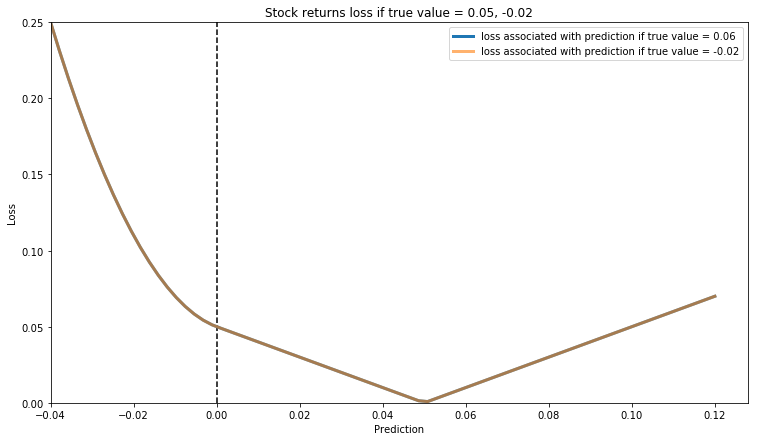

In [13]:
def stock_loss(true_return, yhat, alpha=100.):
    if true_return * yhat < 0:
        return alpha * yhat**2 - np.sign(true_return) * yhat + abs(true_return)
    
    else:
        return abs(true_return - yhat)
    
pred = np.linspace(-.04, .12, 75)

true_value = .05
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred],
         lw=3, label="loss associated with prediction if true value = 0.06")

true_value = .05
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred],
        alpha=0.6, lw=3, label="loss associated with prediction if true value = -0.02")

plt.vlines(0,0,.25, linestyles="--")

plt.xlabel("Prediction")
plt.ylabel("Loss")
plt.xlim(-0.04)
plt.ylim(0, 0.25)
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02")

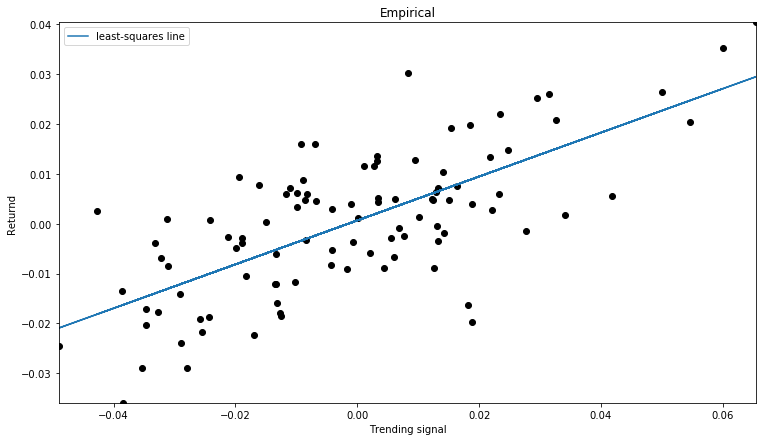

In [17]:
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)

ls_coef_ = np.cov(X, Y)[0, 1] / np.var(X)

ls_intercept = Y.mean() - ls_coef_ * X.mean()

plt.scatter(X,Y,c="k")
plt.plot(X, ls_coef_ * X + ls_intercept, label="least-squares line")

plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())

plt.xlabel("Trending signal")
plt.ylabel("Returnd")
plt.title("Empirical")
plt.legend(loc="upper left")

# Baysian Regression

In [20]:
import pymc as pm

std = pm.Uniform("std", 0, 100, trace=False)

@pm.deterministic
def prec(U=std):
    return 1.0 / U**2

beta = pm.Normal("beta", 0, 0.0001)
alpha = pm.Normal("alpha", 0, 0.0001)

@pm.deterministic
def mean(X=X, alpha=alpha, beta=beta):
    return alpha + beta * X

obs = pm.Normal("obs", mean, prec, value=Y, observed=True)
mcmc = pm.MCMC([obs, beta, alpha, std, prec])

mcmc.sample(100000, 80000)


 [-----------------100%-----------------] 100000 of 100000 complete in 11.4 sec

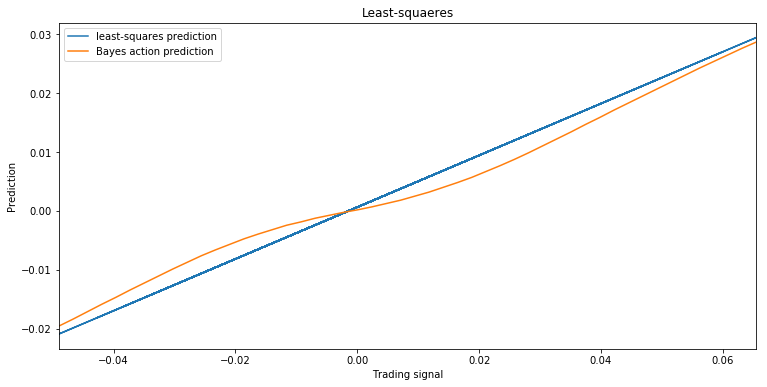

In [34]:
figsize(12.5,6)
from scipy.optimize import fmin

def stock_loss(price, pred, coef=100):
    sol=np.zeros_like(price)
    ix = price * pred < 0
    sol[ix] = coef * pred ** 2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

N = tau_samples.shape[0]
noise = 1. / np.sqrt(tau_samples) * np.random.randn(N)
possible_outcomes = lambda signal: alpha_samples + beta_samples * signal + noise

opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)

for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin,0,disp=False)
    
plt.plot(X, ls_coef_* X + ls_intercept, label="least-squares prediction")
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")

plt.xlim(X.min(), X.max())
plt.xlabel("Trading signal")
plt.ylabel("Prediction")
plt.title("Least-squaeres")
plt.legend(loc="upper left")

In [36]:
print(alpha_samples, beta_samples)

[ 0.00138007  0.00138007  0.00138007 ..., -0.00118227 -0.00098113
 -0.00166626] [ 0.40604427  0.40604427  0.40604427 ...,  0.38328924  0.38328924
  0.38328924]
